In [178]:
%matplotlib inline

import os
import sys
import numpy as np
import pandas as pd
import pickle
from config import ROOT_DIR
import torch
import re
import time
from datetime import date
from matplotlib import pyplot as plt


nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [179]:
plt.rcParams.update({'font.size': 20,'legend.fontsize':16})
np.set_printoptions(linewidth=200)
torch.set_printoptions(linewidth=150, sci_mode=False)

#### Helpers

In [180]:
def get_metric(file_name, today=None):
    if not today:
        today = date.today().strftime("%m_%d")
    return pickle.load(open(ROOT_DIR/'metrics'/f'metrics_{today}_{file_name}.torch', 'rb'))

In [181]:
def get_metric_stats(metric, slc=None):
    if slc:
        metric = [x[slc] for x in metric]
    num_runs = len(metric)
    mean_rewards = [np.mean(x) for x in metric]
    metric_mean = np.around(np.mean(mean_rewards),decimals=4)
    est_ste = np.around(np.std(mean_rewards)/np.sqrt(num_runs),decimals=4)
    return metric_mean, est_ste, len(metric)

In [205]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [182]:
def get_lc_metric_stats(metric, slc=None, episodic=False, ma=None):
    if slc:
        metric = [x[slc] for x in metric]
    if ma is not None:
        metric = [moving_average(single_run, ma) for single_run in metric]
    metric = np.array(metric)
    num_runs = len(metric)
    if episodic:
        metric_mean = np.around(np.mean(metric, axis=0),decimals=4)
        est_ste = np.around(np.std(metric, axis=0)/np.sqrt(num_runs),decimals=4)
    else:
        metric_mean = np.around(np.mean(metric),decimals=4)
        est_ste = np.around(np.std(np.mean(metric, axis=1))/np.sqrt(num_runs),decimals=4)
    num_episodes = len(metric[0])
    return metric_mean, est_ste, num_runs, num_episodes

In [183]:
def gen_agent_data(slc=None):
    for agent_name, collected_metrics in metrics[metric_name].items():
        agent_type = agent_name.split('_')[0]
        agent_type = 'QLearning' if agent_type == 'Random' else agent_type
        agent_data = [agent_type, agent_name]
        for att, pat in zip(agent_attrs, patterns):
            m = pat.search(agent_name)
            if m:
                agent_data.append(m.group(1))
            else:
                agent_data.append(np.nan)
        agent_data.extend(get_metric_stats(collected_metrics,slc=slc))
        yield agent_data

In [185]:
def get_df_from_metric(slc=slice(0,15000)):
    df = pd.concat([pd.DataFrame(data=[data], columns=cols) for data in gen_agent_data(slc=slc)], ignore_index=True)
    df = df.astype({'seq_len': int, 'step_size':float, 'tarnetfreq':int})
    return df

In [186]:
def get_best_agents_from_df(df, groupby):
    filtered_row_idxs = df.groupby(by=groupby,dropna=True)['mean'].idxmax()
    result = df.loc[filtered_row_idxs]
    return result

In [187]:
agent_attrs = ["step_size", "seq_len", "init", 'tarnetfreq', 'num_quant', 'per_alpha']
patterns = [re.compile(rf"{att}_(.*?)(?:_|$)") for att in agent_attrs]
cols = ['agent_type', 'agent_name', *agent_attrs, 'mean', 'ste', 'num_runs']
metric_name = "episodic_returns"

In [188]:
agent_types = ["QLearning", "PER", "QR"]
labels = [
    *agent_types
]
default_color_cycle = list(plt.get_cmap('Set1').colors)
default_color_map = {k:v for k,v in zip(labels, default_color_cycle)}

### Transform Experiment Results to Dataframe

In [199]:
metrics = get_metric('pw_tc_param_search_1', "11_01")
df = get_df_from_metric()
df_best = get_best_agents_from_df(df, groupby=['agent_type', 'seq_len'])
df_best

,agent_type,agent_name,step_size,seq_len,init,tarnetfreq,num_quant,per_alpha,mean,ste,num_runs
7,PER,PER_step_size_0.125_seq_len_5_ptype_1_per_alph...,0.125,5,0,1,NaN,0.2,-30.3263,4.2288,3
12,QLearning,QLearning_step_size_0.5_seq_len_5_opt_sgd_init...,0.500,5,0,1,NaN,NaN,-13.6455,2.7378,3
8,QR,QR_step_size_1.0_seq_len_5_opt_sgd_init_0_tarn...,1.000,5,0,1,2,NaN,-23.7623,5.3694,3


### Sensitivity Analysis

In [192]:
df = df.loc[df.groupby(by=['agent_type', 'step_size'],dropna=True)['mean'].idxmax()]
df = df.sort_values('step_size')

Text(0.5, 1.0, 'Sensitivity Analysis')

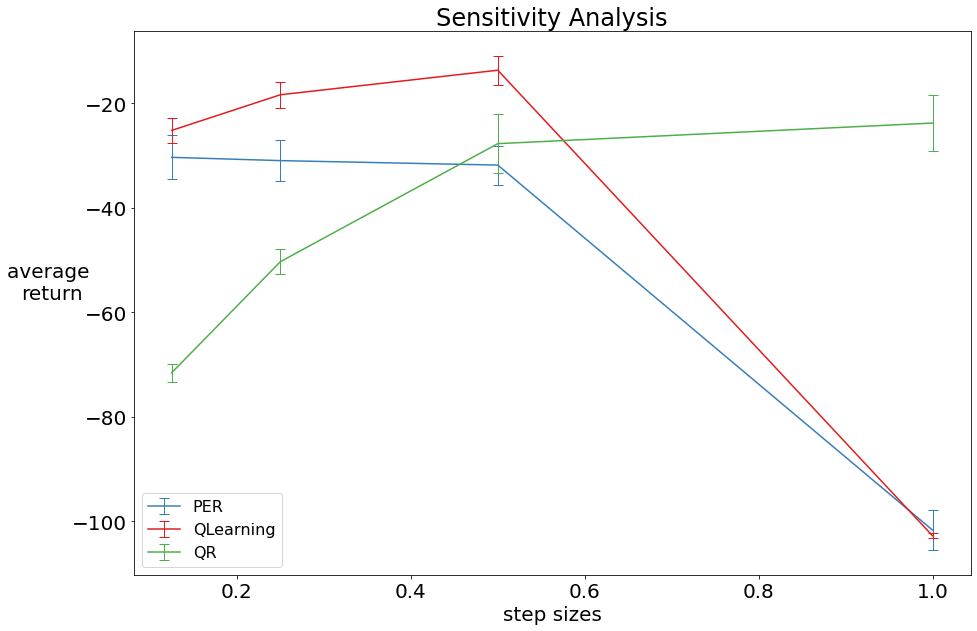

In [197]:
plt.figure(figsize=(15,10))
x_values = sorted(df.step_size.unique())
for k, agent_type in enumerate(sorted(df['agent_type'].unique())):
    df_by_agent_type = df[df.agent_type == agent_type]
    plt.errorbar(x_values, df_by_agent_type['mean'].tolist(), yerr=df_by_agent_type['ste'].tolist(), label=agent_type, color=default_color_map[agent_type], capsize=5, elinewidth=1)
plt.ylabel("average \nreturn", rotation=0, labelpad=20)
plt.xlabel('step sizes')
plt.legend()
plt.title(f"Sensitivity Analysis")

Observations:
1. Vanilla Q-learning agent performs generally better than the other replay agent variants in Puddle World
2. Quantile regression agent tends to perform better under a larger step size while PER and Q-learning agents peaks performance at a smaller step size
3. In this example, both QR and PER agents peak performance at a extreme value of the chosen step size range, we would want to expand this range in practice

### Online Performance Comparison

In [201]:
metrics = get_metric('pw_tc_best_agent_variants', "11_01")
df = get_df_from_metric()
df_best = get_best_agents_from_df(df, groupby=['agent_type', 'seq_len'])
df_best

,agent_type,agent_name,step_size,seq_len,init,tarnetfreq,num_quant,per_alpha,mean,ste,num_runs
1,PER,PER_step_size_0.125_seq_len_5_ptype_1_per_alph...,0.125,5,0,1,NaN,0.2,-28.7103,2.5604,10
0,QLearning,QLearning_step_size_0.5_seq_len_5_opt_sgd_init...,0.500,5,0,1,NaN,NaN,-22.8635,4.6456,10
2,QR,QR_step_size_1_seq_len_5_opt_sgd_init_0_tarnet...,1.000,5,0,1,2,NaN,-23.2887,3.1013,10


Text(0.5, 1.0, 'Puddle World')

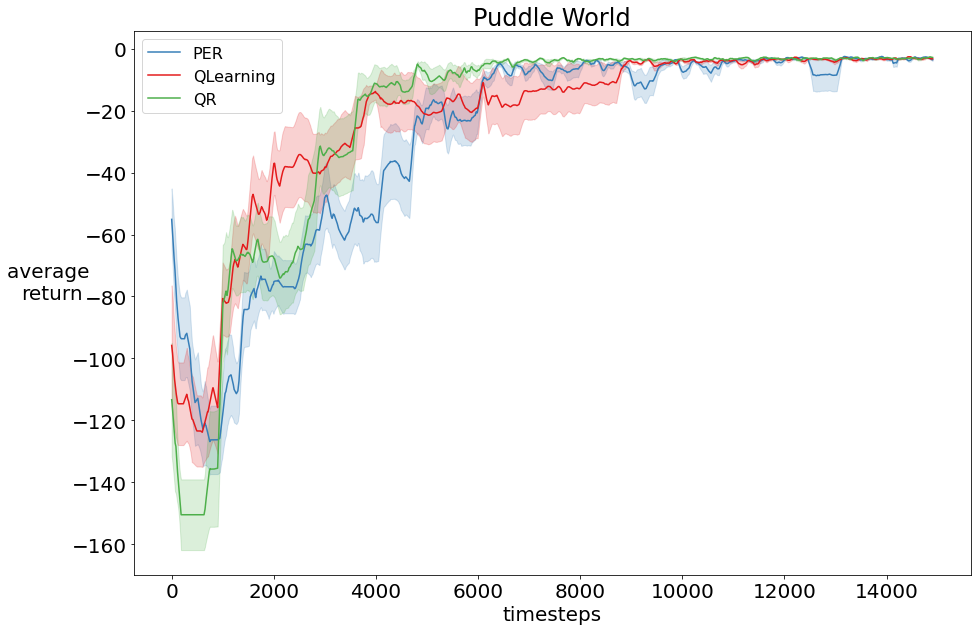

In [207]:
plt.figure(figsize=(15,10))
agent_names = df_best.agent_name.tolist()
for agent_name in agent_names:
    metric = metrics[metric_name][agent_name]
    means, stes, _,num_episodes = get_lc_metric_stats(metric, slice(15000), episodic=True,ma=100)
    agent_type = agent_name.split('_')[0]
    # print(label, np.around(np.mean(means),decimals=4), np.around(np.std(np.mean(metric, axis=1))/np.sqrt(num_runs),decimals=4))
    color = default_color_map.get(agent_type)
    plt.plot(means, label=laagent_typebel, alpha=1, color=color)
    plt.fill_between(range(num_episodes), means + stes, means - stes, alpha=0.2, color=color)
plt.ylabel("average \nreturn", rotation=0, labelpad=20)
plt.xlabel('timesteps')
plt.legend()
plt.title(f"Puddle World")

Notes:
1. In this example, I only scheduled 3 runs for hyperparam search and 10 independent runs for the performance comparison. More runs seem needed in this case to observe a significant result  
2. PuddleWorld is known for a stability challenge from having to learn a large negative reward, where methods such as PER usually requires more extensive param tuning
3. Other metrics or visualizations could also be useful to help the evaluation (e.g. learned value function)